## 1) Setup & imports

In [8]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

RNG = 42
np.random.seed(RNG)

In [12]:
# 1. Load dataset
# ---------------------------
cols = ["Sex", "Length", "Diameter", "Height", "WholeWeight", "ShuckedWeight",
        "VisceraWeight", "ShellWeight", "Rings"]
df = pd.read_csv("abalone.data.csv", header=None, names=cols)

# Basic cleaning
df["Sex"] = df["Sex"].astype(str).str.strip() # force elements in 'sex' into string and eliminate spaces
for c in df.columns:
    if c != "Sex":
        df[c] = pd.to_numeric(df[c], errors="coerce") # force elements in all columns(except 'sex') into numerical values
df = df[df["Sex"].isin(["M", "F", "I"])] # eliminate rows containing error value in column 'sex'
df = df.dropna().reset_index(drop=True) # drop rows containing 'NaN' and reset index numbers

# 2. Construct target variable (Age)
# ---------------------------
df['Age'] = df['Rings'] + 1.5
df = df.drop(columns=['Rings'])

# 3. Define X / y
# ---------------------------
X = df.drop(columns=['Age'])  #features
y = df['Age'] # target

# 3.1 Feature engineering
def add_features(X_):
    X_ = X_.copy()
    eps = 1e-8

    # Use ellipsoid volume approximation instead of cylinder
    # Volume of ellipsoid: V = (4/3) * π * a * b * c
    # where a, b, c are semi-axes: Length/2, Diameter/2, Height/2
    vol = (4/3) * np.pi * (X_["Length"] / 2) * (X_["Diameter"] / 2) * (X_["Height"] / 2)
    vol = vol.replace(0, np.nan)

    X_["DensityWhole"] = X_["WholeWeight"] / (vol + eps)
    X_["MeatRatio"] = X_["ShuckedWeight"] / (X_["WholeWeight"] + eps)
    X_["VisceraRatio"] = X_["VisceraWeight"] / (X_["WholeWeight"] + eps)
    X_["ShellRatio"] = X_["ShellWeight"] / (X_["WholeWeight"] + eps)
    X_["Length_Diameter"] = X_["Length"] * X_["Diameter"]
    X_["Height_Shell"] = X_["Height"] * X_["ShellWeight"]

    X_ = X_.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return X_

X = add_features(X)

# 3.2 IQR outlier clipping - moved to ColumnTransformer to avoid data leakage
from sklearn.base import BaseEstimator, TransformerMixin

class IQRClipTransformer(BaseEstimator, TransformerMixin):
    """IQR-based outlier clipping transformer"""
    def __init__(self):
        self.low_ = None
        self.high_ = None
    
    def fit(self, X, y=None):
        q1 = np.quantile(X, 0.25, axis=0)
        q3 = np.quantile(X, 0.75, axis=0)
        iqr = q3 - q1               # iqr stands for the spread of the middle 50% of the data
        self.low_ = q1 - 1.5 * iqr
        self.high_ = q3 + 1.5 * iqr
        return self
    
    def transform(self, X):
        # Clip each column independently using broadcasting
        X_clipped = np.clip(X, self.low_, self.high_)
        return X_clipped

# 4. ColumnTransformer (unified preprocessing)
# ---------------------------
categorical_cols = ["Sex"]
numeric_cols = [c for c in X.columns if c != "Sex"]

preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
    ('num', Pipeline([
        ('iqr_clip', IQRClipTransformer()),
        ('scaler', StandardScaler())
    ]), numeric_cols)
])

# Full preprocessing pipeline
#full_preprocess = Pipeline([('ct', preprocess)])

# 5. Train/Test Split with stratification on binned Age
# ---------------------------
age_bins = pd.qcut(y, q=10, duplicates='drop') # 10 bins
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RNG,
    stratify=age_bins       #Stratified Sampling
)

print("Train:", X_train.shape, "Test:", X_test.shape)

# 6. Cross-validation splitter for modelling
cv_bins = pd.qcut(y_train, q=5, duplicates='drop')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)

Train: (3341, 14) Test: (836, 14)


## 3)Ridge Regression

In [15]:
pipe_ridge = Pipeline([
    ('prep', preprocess),
    ('reg', Ridge())
])

# Define parameter grid
param_grid_ridge = {
    'reg__alpha': [0.01, 0.1, 1, 3, 10, 30, 100] 
}

# GridSearchCV（5-fold CV）
grid_ridge = GridSearchCV(
    estimator=pipe_ridge,
    param_grid=param_grid_ridge,
    scoring='r2',
    cv=5,
    n_jobs=-1
)

# Record training time
start_time = time.time()
grid_ridge.fit(X_train, y_train)
end_time = time.time()
ridge_train_time = end_time - start_time

print("Best Parameters:", grid_ridge.best_params_)
print("Best CV R²:", grid_ridge.best_score_)
print("Training Time (s):", ridge_train_time)

# Evaluation
best_ridge = grid_ridge.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)

ridge_mse = mean_squared_error(y_test, y_pred_ridge)
ridge_mae = mean_absolute_error(y_test, y_pred_ridge)
ridge_r2  = r2_score(y_test, y_pred_ridge)

print("\n--- Ridge Test Performance ---")
print("MSE:", ridge_mse)
print("MAE:", ridge_mae)
print("R² :", ridge_r2)

Best Parameters: {'reg__alpha': 3}
Best CV R²: 0.5698577970602147
Training Time (s): 1.6238749027252197

--- Ridge Test Performance ---
MSE: 4.699802524605724
MAE: 1.5876755563107476
R² : 0.5606152232695589


## 4) SVR

In [8]:
pipe_svr = Pipeline([
    ('prep', preprocess),
    ('reg', SVR())
])

param_grid_svr = {
    'reg__C': [1, 3, 10, 30, 100],
    'reg__gamma': ['scale', 0.1, 0.03, 0.01, 0.003],
    'reg__epsilon': [0.1, 0.2, 0.3]
}

grid_svr = GridSearchCV(
    estimator=pipe_svr,
    param_grid=param_grid_svr,
    scoring='r2',
    cv=5,
    n_jobs=-1
)

start_time = time.time()
grid_svr.fit(X_train, y_train)
end_time = time.time()
svr_train_time = end_time - start_time

print("Best Parameters:", grid_svr.best_params_)
print("Best CV R²:", grid_svr.best_score_)
print("Training Time (s):", svr_train_time)

best_svr = grid_svr.best_estimator_
y_pred_svr = best_svr.predict(X_test)

svr_mse = mean_squared_error(y_test, y_pred_svr)
svr_mae = mean_absolute_error(y_test, y_pred_svr)
svr_r2  = r2_score(y_test, y_pred_svr)

print("\n--- SVR Test Performance ---")
print("MSE:", svr_mse)
print("MAE:", svr_mae)
print("R² :", svr_r2)


Best Parameters: {'reg__C': 10, 'reg__epsilon': 0.3, 'reg__gamma': 0.1}
Best CV R²: 0.5619356994307403
Training Time (s): 15.337344884872437

--- SVR Test Performance ---
MSE: 4.674624831586784
MAE: 1.4785861543149177
R² : 0.568172366918169


## 5) Random Forest

In [21]:
pipe_rf = Pipeline([
    ('prep', preprocess),
    ('reg', RandomForestRegressor(random_state=42))
])

param_grid_rf = {
    'reg__n_estimators': [200, 400, 800],
    'reg__max_depth': [None, 8, 12, 16],
    'reg__min_samples_split': [2, 5, 10],
    'reg__min_samples_leaf': [1, 2, 4],
    'reg__max_features': ['sqrt', 0.5, 1.0]
}

grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    scoring='r2',
    cv=5,
    n_jobs=-1
)

start_time = time.time()
grid_rf.fit(X_train, y_train)
end_time = time.time()
rf_train_time = end_time - start_time

print("Best Parameters:", grid_rf.best_params_)
print("Best CV R²:", grid_rf.best_score_)
print("Training Time (s):", rf_train_time)

best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_r2  = r2_score(y_test, y_pred_rf)

print("\n--- Random Forest Test Performance ---")
print("MSE:", rf_mse)
print("MAE:", rf_mae)
print("R² :", rf_r2)


Best Parameters: {'reg__max_depth': 12, 'reg__max_features': 0.5, 'reg__min_samples_leaf': 4, 'reg__min_samples_split': 10, 'reg__n_estimators': 400}
Best CV R²: 0.5623069862209691
Training Time (s): 446.50045371055603

--- Random Forest Test Performance ---
MSE: 4.8001584260699826
MAE: 1.5413562804430645
R² : 0.5565759550282476


## 6）Performance Analysis

           Model  Train_Time(s)      RMSE       MAE        R2
1            SVR      15.337345  2.162088  1.478586  0.568172
2  Random Forest     446.500454  2.190926  1.541356  0.556576
0          Ridge       1.391291  2.211610  1.593930  0.548164


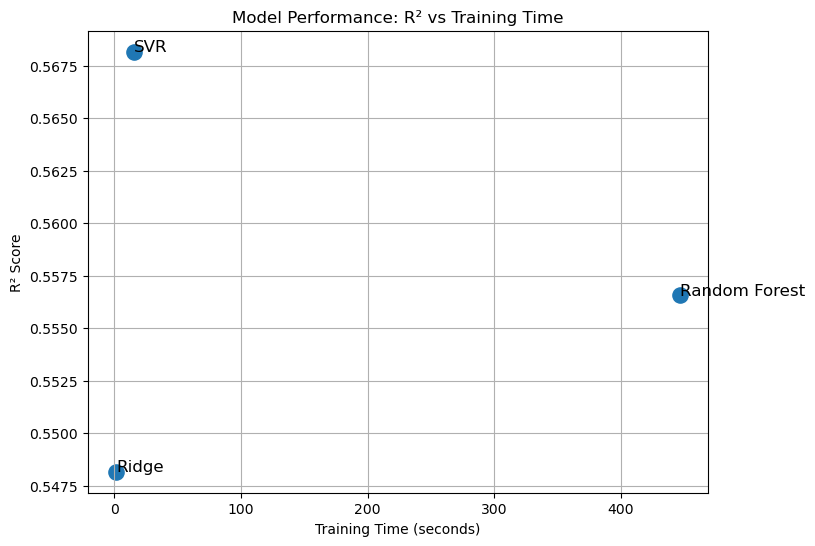

In [27]:
rows = [
    ["Ridge", ridge_train_time, np.sqrt(ridge_mse), ridge_mae, ridge_r2],
    ["SVR", svr_train_time, np.sqrt(svr_mse), svr_mae, svr_r2],
    ["Random Forest", rf_train_time, np.sqrt(rf_mse), rf_mae, rf_r2]
]
df_results = pd.DataFrame(rows, columns=["Model", "Train_Time(s)", "RMSE", "MAE", "R2"]).sort_values("R2", ascending=False)
print(df_results)


model_names = ['Ridge', 'SVR', 'Random Forest']
r2_scores = [
    ridge_r2,   
    svr_r2,     
    rf_r2
]

plt.figure(figsize=(8,6))
plt.scatter(train_times, r2_scores, s=120)

for i, name in enumerate(model_names):
    plt.text(train_times[i] + 0.01, r2_scores[i], name, fontsize=12)

plt.xlabel("Training Time (seconds)")
plt.ylabel("R² Score")
plt.title("Model Performance: R² vs Training Time")
plt.grid(True)

plt.show()
